In [60]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [61]:
path='https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
data=pd.read_csv(path)
data.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [62]:
#Value Checking
data.groupby(['SEVERITYCODE'])['STATUS'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['ADDRTYPE'].value_counts(normalize=True) #Block & Intersection happen incidents a lot more than Alley 
data.groupby(['SEVERITYCODE'])['SDOT_COLDESC'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['INATTENTIONIND'].value_counts(normalize=True)#The result shows that 100% of collision were incurred by inattention
data.groupby(['SEVERITYCODE'])['UNDERINFL'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['WEATHER'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['PEDROWNOTGRNT'].value_counts(normalize=True) #It shows pedestrians have the right of way in 100% incidents
data.groupby(['SEVERITYCODE'])['SPEEDING'].value_counts(normalize=True) #It shows 100% incidents relate to speed.
data.groupby(['SEVERITYCODE'])['ST_COLCODE'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['ST_COLDESC'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['HITPARKEDCAR'].value_counts(normalize=True) #Over 95% of inccidents did not hit the parked cars.
data.groupby(['SEVERITYCODE'])['REPORTNO'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['LOCATION'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['SEVERITYDESC'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['COLLISIONTYPE'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['JUNCTIONTYPE'].value_counts(normalize=True) #It looks like junction type will be one of the factors
data.groupby(['SEVERITYCODE'])['SDOT_COLDESC'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts(normalize=True)
data.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True)

SEVERITYCODE  LIGHTCOND               
1             Daylight                    0.586028
              Dark - Street Lights On     0.257030
              Unknown                     0.097187
              Dusk                        0.029893
              Dawn                        0.012673
              Dark - No Street Lights     0.009086
              Dark - Street Lights Off    0.006669
              Other                       0.001382
              Dark - Unknown Lighting     0.000053
2             Daylight                    0.675050
              Dark - Street Lights On     0.253512
              Dusk                        0.034047
              Dawn                        0.014431
              Unknown                     0.010596
              Dark - No Street Lights     0.005850
              Dark - Street Lights Off    0.005534
              Other                       0.000911
              Dark - Unknown Lighting     0.000070
Name: LIGHTCOND, dtype: float64

In [63]:
#Pre-processing

#SEVERITYCODE.1 is repeated so drop the column
data.drop("SEVERITYCODE.1", axis=1, inplace=True)

#Convert Categorical features to numerical value

data['STATUS'].replace(to_replace=['Matched','Unmatched'], value=[1,0],inplace=True) #almost 100% matched
data['ADDRTYPE'].replace(to_replace=['Block','Intersection', 'Alley'], value=[1, 2, 3],inplace=True)

#Weather clear condition is nearly 60% for both severity codes. The options also include unknown and other which cannot be analyzed
#Therefore, I normalize the data to good weather (clear - 1), nothing to do with weather (unknown & other - 0), bad weather (the rest -2)
data['WEATHER'].replace(to_replace=['Clear', 'Raining', 'Overcast', 'Unknown', 'Fog/Smog/Smoke', 'Snowing', 'Other', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy'], value=[1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2],inplace=True)
data['HITPARKEDCAR'].replace(to_replace=['N', 'Y'], value=[0, 1], inplace=True)

#drop X and Y column, for not specifying the meaning
data.drop('X', axis=1, inplace=True)
data.drop('Y', axis=1, inplace=True)

#drop columns that have over half NaN values
data.drop(['EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INTKEY', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING'], axis=1, inplace=True)

#report no. has nothing to do with severity so drop
data.drop(['REPORTNO'], axis=1, inplace=True)

data['SEVERITYDESC'].replace(to_replace=['Property Damage Only Collision', 'Injury Collision'], value=[1, 2], inplace=True)
data['COLLISIONTYPE'].replace(to_replace=['Parked Car', 'Angles', 'Rear Ended', 'Other', 'Sideswipe', 'Left Turn', 'Right Turn', 'Head On', 'Pedestrian', 'Cycles'], value=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True) 

#OBJECTID is only for each case so drop
data.drop(['OBJECTID'], axis=1, inplace=True)

# INCDATE,INCDTTM is only for each case so drop
data.drop(['INCDATE', 'INCDTTM'], axis=1, inplace=True)

data['JUNCTIONTYPE'].replace(to_replace=['At Intersection (intersection related)', 'Mid-Block (not related to intersection)','Mid-Block (but intersection related)','Driveway Junction', 'At Intersection (but not related to intersection)', 'Ramp Junction', 'Unknown'], value=[1, 2, 3, 4, 5, 6, 7], inplace=True)

#Location has very little to do with severity so drop
data.drop(['LOCATION'], axis=1, inplace=True)

#SDOTCOLNUM has too many NAN to analyze so drop
data.drop(['SDOTCOLNUM'], axis=1, inplace=True)

data['ROADCOND'].replace(to_replace=['Dry','Wet', 'Unknown', 'Ice', 'Snow/Slush'
                                    'Other', 'Standing Water', 'Sand/Mud/Dirt',
                                    'Oil'], value=[1, 2, 3, 4, 5, 6, 7, 8],
                        inplace=True)
data['ROADCOND'] = pd.to_numeric(data.ROADCOND, errors='coerce')

data['LIGHTCOND'].replace(to_replace=['Daylight', 'Dark - Street Lights On', 'Unknown',
                                     'Dusk', 'Dawn', 'Dark - No Street Lights', 
                                     'Dark - Street Lights Off', 'Other', 'Dark - Unknown Lighting'],
                         value=[1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)

data['ST_COLCODE'] = pd.to_numeric(data.ST_COLCODE, errors='coerce')
data['SDOT_COLCODE'] = pd.to_numeric(data.ST_COLCODE, errors='coerce')

#drop desc but keep code
data.drop(['SDOT_COLDESC', 'ST_COLDESC'], axis=1, inplace=True)

#cannot make sure the relationship with Y/N and 1/0 so drop
data.drop(['UNDERINFL'], axis=1, inplace=True)

#COLDETKEY only for each case so drop
data.drop(['COLDETKEY'], axis=1, inplace=True)

#INCKEY only for each case so drop
data.drop(['INCKEY'], axis=1, inplace=True)

#drop as correlations are too low to analyze
data.drop(['STATUS', 'VEHCOUNT', 'JUNCTIONTYPE', 'LIGHTCOND'], axis=1, inplace=True)

data.head()

,SEVERITYCODE,ADDRTYPE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,SDOT_COLCODE,WEATHER,ROADCOND,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,2.0,2,2.0,2,0,0,10.0,2.0,2.0,10.0,0,0,0
1,1,1.0,1,5.0,2,0,0,11.0,2.0,2.0,11.0,0,0,0
2,1,1.0,1,1.0,4,0,0,32.0,2.0,1.0,32.0,0,0,0
3,1,1.0,1,4.0,3,0,0,23.0,1.0,1.0,23.0,0,0,0
4,2,2.0,2,2.0,2,0,0,10.0,2.0,2.0,10.0,0,0,0


In [64]:
data.isna().sum()

SEVERITYCODE        0
ADDRTYPE         1926
SEVERITYDESC        0
COLLISIONTYPE    4904
PERSONCOUNT         0
PEDCOUNT            0
PEDCYLCOUNT         0
SDOT_COLCODE     4904
WEATHER          5081
ROADCOND         6148
ST_COLCODE       4904
SEGLANEKEY          0
CROSSWALKKEY        0
HITPARKEDCAR        0
dtype: int64

In [65]:
# replace 3% incomplete samples with mean of that feature
mean=data['COLLISIONTYPE'].mean()
data['COLLISIONTYPE'].replace(np.nan,mean, inplace=True)
mean=data['ADDRTYPE'].mean()
data['ADDRTYPE'].replace(np.nan,mean, inplace=True)
mean=data['SDOT_COLCODE'].mean()
data['SDOT_COLCODE'].replace(np.nan,mean, inplace=True)
mean=data['WEATHER'].mean()
data['WEATHER'].replace(np.nan,mean, inplace=True)
mean=data['ROADCOND'].mean()
data['ROADCOND'].replace(np.nan,mean, inplace=True)
mean=data['ST_COLCODE'].mean()
data['ST_COLCODE'].replace(np.nan,mean, inplace=True)
data.isna().sum()

SEVERITYCODE     0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
SDOT_COLCODE     0
WEATHER          0
ROADCOND         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
dtype: int64

In [66]:
data.corr()['SEVERITYCODE'].sort_values().round(4)

SDOT_COLCODE    -0.1630
ST_COLCODE      -0.1630
ROADCOND        -0.1058
HITPARKEDCAR    -0.1015
WEATHER          0.1025
SEGLANEKEY       0.1043
PERSONCOUNT      0.1309
CROSSWALKKEY     0.1751
ADDRTYPE         0.1854
PEDCYLCOUNT      0.2142
PEDCOUNT         0.2463
COLLISIONTYPE    0.3069
SEVERITYCODE     1.0000
SEVERITYDESC     1.0000
Name: SEVERITYCODE, dtype: float64

In [67]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') 
print ('Matplotlib version: ', mpl.__version__) 

Matplotlib version:  3.3.0


In [68]:
Feature = data[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']]
X = Feature
X[0:5]

,ADDRTYPE,SEVERITYDESC,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,SDOT_COLCODE,ST_COLCODE,CROSSWALKKEY
0,2.0,2,2.0,0,0,10.0,10.0,0
1,1.0,1,5.0,0,0,11.0,11.0,0
2,1.0,1,1.0,0,0,32.0,32.0,0
3,1.0,1,4.0,0,0,23.0,23.0,0
4,2.0,2,2.0,0,0,10.0,10.0,0


In [69]:
y = data['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2])

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (155738, 8) (155738,)
Test set: (38935, 8) (38935,)


In [71]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 1.36032213,  1.53153084, -0.59923991, -0.18743029, -0.16958841,
        -0.89714424, -0.89714424, -0.13536153],
       [-0.71772827, -0.65294147,  0.70961907, -0.18743029, -0.16958841,
        -0.82737004, -0.82737004, -0.13536153],
       [-0.71772827, -0.65294147, -1.03552623, -0.18743029, -0.16958841,
         0.63788817,  0.63788817, -0.13536153],
       [-0.71772827, -0.65294147,  0.27333274, -0.18743029, -0.16958841,
         0.00992036,  0.00992036, -0.13536153],
       [ 1.36032213,  1.53153084, -0.59923991, -0.18743029, -0.16958841,
        -0.89714424, -0.89714424, -0.13536153]])

In [72]:
#Training

from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
yhat[0:5]

array([2, 1, 1, 2, 2])

In [73]:
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.99691794, 0.9955567 , 0.99709773, 0.99689226, 0.99743162,
       0.9974573 , 0.99753435, 0.99740593, 0.99748298])

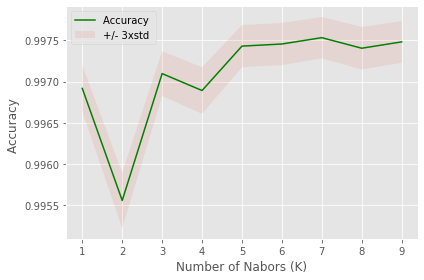

The best accuracy was with 0.9975343521253371 with k= 7


In [74]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [75]:
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [76]:
#Model Evaluation 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [77]:
# f1_score 
KNN_f1_test=f1_score(y_test, yhat, average='weighted').round(2)

# jaccard index for accuracy
KNN_ja_test=jaccard_similarity_score(y_test, yhat).round(2)

print("Jaccard:", KNN_ja_test)
print("F1 score:", KNN_f1_test)

Jaccard: 1.0
F1 score: 1.0


In [78]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [79]:
predTree = loanTree.predict(X_test)
predTree

array([2, 1, 1, ..., 1, 1, 2])

In [80]:
# f1_score 
tree_f1_test=f1_score(y_test, yhat, average='weighted').round(2)

# jaccard index for accuracy
tree_ja_test=jaccard_similarity_score(y_test, yhat).round(2)

print("Jaccard:", tree_ja_test)
print("F1 score:", tree_f1_test)

Jaccard: 1.0
F1 score: 1.0


In [81]:
#SVM
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
yhat

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([2, 1, 1, ..., 1, 1, 2])

In [82]:
# f1_score 
svm_f1_test=f1_score(y_test, yhat, average='weighted').round(2)

# jaccard index for accuracy
svm_ja_test=jaccard_similarity_score(y_test, yhat).round(2)

print("Jaccard:", svm_ja_test)
print("F1 score:", svm_f1_test)

Jaccard: 1.0
F1 score: 1.0


In [83]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01).fit(X_train, y_train)
LR

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
yhat = LR.predict(X_test)
yhat

array([2, 1, 1, ..., 1, 1, 2])

In [85]:
yhat_prob_test = LR.predict_proba(X_test)

# log loss for evaluation
LR_loss_test=log_loss(y_test, yhat_prob_test).round(2)

# jaccard index for accuracy:
LR_ja_test=jaccard_similarity_score(y_test, yhat).round(2)

# f1_score 
LR_f1_test=f1_score(y_test, yhat, average='weighted').round(2)

print("Jaccard:", LR_ja_test)
print("F1 score:", LR_f1_test)
print("LogLoss:", LR_loss_test)

Jaccard: 0.92
F1 score: 0.91
LogLoss: 0.35


In [86]:
data = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'],'Jaccard': [KNN_ja_test, tree_ja_test, svm_ja_test, LR_ja_test], 'F1-score': [KNN_f1_test, tree_f1_test, svm_f1_test, LR_f1_test], 'LogLoss': ['NA', 'NA', 'NA', LR_loss_test]}
report=pd.DataFrame.from_dict(data)
report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,1.00,1.00,NA
1,Decision Tree,1.00,1.00,NA
2,SVM,1.00,1.00,NA
3,LogisticRegression,0.92,0.91,0.35


In [87]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

path='https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
data=pd.read_csv(path)

#Pre-processing
#SEVERITYCODE.1 is repeated so drop the column
data.drop("SEVERITYCODE.1", axis=1, inplace=True)

#Convert Categorical features to numerical value

data['STATUS'].replace(to_replace=['Matched','Unmatched'], value=[1,0],inplace=True) #almost 100% matched
data['ADDRTYPE'].replace(to_replace=['Block','Intersection', 'Alley'], value=[1, 2, 3],inplace=True)

#Weather clear condition is nearly 60% for both severity codes. The options also include unknown and other which cannot be analyzed
#Therefore, I normalize the data to good weather (clear - 1), nothing to do with weather (unknown & other - 0), bad weather (the rest -2)
data['WEATHER'].replace(to_replace=['Clear', 'Raining', 'Overcast', 'Unknown', 'Fog/Smog/Smoke', 'Snowing', 'Other', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy'], value=[1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2],inplace=True)
data['HITPARKEDCAR'].replace(to_replace=['N', 'Y'], value=[0, 1], inplace=True)

#drop X and Y column, for not specifying the meaning
data.drop('X', axis=1, inplace=True)
data.drop('Y', axis=1, inplace=True)

#drop columns that have over half NaN values
data.drop(['EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INTKEY', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING'], axis=1, inplace=True)

#report no. has nothing to do with severity so drop
data.drop(['REPORTNO'], axis=1, inplace=True)

data['SEVERITYDESC'].replace(to_replace=['Property Damage Only Collision', 'Injury Collision'], value=[1, 2], inplace=True)
data['COLLISIONTYPE'].replace(to_replace=['Parked Car', 'Angles', 'Rear Ended', 'Other', 'Sideswipe', 'Left Turn', 'Right Turn', 'Head On', 'Pedestrian', 'Cycles'], value=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True) 

#OBJECTID is only for each case so drop
data.drop(['OBJECTID'], axis=1, inplace=True)

# INCDATE,INCDTTM is only for each case so drop
data.drop(['INCDATE', 'INCDTTM'], axis=1, inplace=True)

data['JUNCTIONTYPE'].replace(to_replace=['At Intersection (intersection related)', 'Mid-Block (not related to intersection)','Mid-Block (but intersection related)','Driveway Junction', 'At Intersection (but not related to intersection)', 'Ramp Junction', 'Unknown'], value=[1, 2, 3, 4, 5, 6, 7], inplace=True)

#Location has very little to do with severity so drop
data.drop(['LOCATION'], axis=1, inplace=True)

#SDOTCOLNUM has too many NAN to analyze so drop
data.drop(['SDOTCOLNUM'], axis=1, inplace=True)

data['ROADCOND'].replace(to_replace=['Dry','Wet', 'Unknown', 'Ice', 'Snow/Slush'
                                    'Other', 'Standing Water', 'Sand/Mud/Dirt',
                                    'Oil'], value=[1, 2, 3, 4, 5, 6, 7, 8],
                        inplace=True)
data['ROADCOND'] = pd.to_numeric(data.ROADCOND, errors='coerce')

data['LIGHTCOND'].replace(to_replace=['Daylight', 'Dark - Street Lights On', 'Unknown',
                                     'Dusk', 'Dawn', 'Dark - No Street Lights', 
                                     'Dark - Street Lights Off', 'Other', 'Dark - Unknown Lighting'],
                         value=[1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)

data['ST_COLCODE'] = pd.to_numeric(data.ST_COLCODE, errors='coerce')
data['SDOT_COLCODE'] = pd.to_numeric(data.ST_COLCODE, errors='coerce')

#drop desc but keep code
data.drop(['SDOT_COLDESC', 'ST_COLDESC'], axis=1, inplace=True)

#cannot make sure the relationship with Y/N and 1/0 so drop
data.drop(['UNDERINFL'], axis=1, inplace=True)

#COLDETKEY only for each case so drop
data.drop(['COLDETKEY'], axis=1, inplace=True)

#INCKEY only for each case so drop
data.drop(['INCKEY'], axis=1, inplace=True)

#drop as correlations are too low to analyze
data.drop(['STATUS', 'VEHCOUNT', 'JUNCTIONTYPE', 'LIGHTCOND'], axis=1, inplace=True)

# replace 3% incomplete samples with mean of that feature
mean=data['COLLISIONTYPE'].mean()
data['COLLISIONTYPE'].replace(np.nan,mean, inplace=True)
mean=data['ADDRTYPE'].mean()
data['ADDRTYPE'].replace(np.nan,mean, inplace=True)
mean=data['SDOT_COLCODE'].mean()
data['SDOT_COLCODE'].replace(np.nan,mean, inplace=True)
mean=data['WEATHER'].mean()
data['WEATHER'].replace(np.nan,mean, inplace=True)
mean=data['ROADCOND'].mean()
data['ROADCOND'].replace(np.nan,mean, inplace=True)
mean=data['ST_COLCODE'].mean()
data['ST_COLCODE'].replace(np.nan,mean, inplace=True)
data.isna().sum()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


SEVERITYCODE     0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
SDOT_COLCODE     0
WEATHER          0
ROADCOND         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
dtype: int64

In [88]:
data.corr()['SEVERITYCODE'].sort_values().round(4)

SDOT_COLCODE    -0.1630
ST_COLCODE      -0.1630
ROADCOND        -0.1058
HITPARKEDCAR    -0.1015
WEATHER          0.1025
SEGLANEKEY       0.1043
PERSONCOUNT      0.1309
CROSSWALKKEY     0.1751
ADDRTYPE         0.1854
PEDCYLCOUNT      0.2142
PEDCOUNT         0.2463
COLLISIONTYPE    0.3069
SEVERITYCODE     1.0000
SEVERITYDESC     1.0000
Name: SEVERITYCODE, dtype: float64

In [89]:
#Build Regression Model
X1 = data[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY', 'SEVERITYCODE']]
X1[0:5]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

In [90]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 5.03092900e-12  1.00000000e+00  4.17623584e-13 -3.03688861e-11
  -3.53582124e-12 -1.51234006e-14  1.34492298e-14  1.11022302e-16]]
Intercept:  [-7.01860792e-12]


In [91]:
x = np.asanyarray(test[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

R8=regr.score(x, y).round(4)
R8

Residual sum of squares: 0.00


1.0

In [92]:
#Remove 'SEVERITYDESC'
X1 = data[['ADDRTYPE','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY', 'SEVERITYCODE']]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['ADDRTYPE','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 9.31831456e-02  2.67610658e-02  3.35570158e-01  4.67999636e-01
  -2.17977631e-03 -2.17977631e-03 -4.16592110e-08]]
Intercept:  [1.15727755]


In [93]:
#Remove 'SEVERITYDESC'
x = np.asanyarray(test[['ADDRTYPE','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['ADDRTYPE','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
               'SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 0.18
Variance score: 0.15


In [94]:
data.corr()['SEVERITYCODE'].sort_values().round(4)

SDOT_COLCODE    -0.1630
ST_COLCODE      -0.1630
ROADCOND        -0.1058
HITPARKEDCAR    -0.1015
WEATHER          0.1025
SEGLANEKEY       0.1043
PERSONCOUNT      0.1309
CROSSWALKKEY     0.1751
ADDRTYPE         0.1854
PEDCYLCOUNT      0.2142
PEDCOUNT         0.2463
COLLISIONTYPE    0.3069
SEVERITYCODE     1.0000
SEVERITYDESC     1.0000
Name: SEVERITYCODE, dtype: float64

In [95]:
#Keep only corr score over 0.2
X1 = data[['SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SEVERITYCODE']]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)


Coefficients:  [[ 1.00000000e+00 -4.37761921e-17  2.98213901e-17  2.69186285e-17]]
Intercept:  [-6.88338275e-15]


In [96]:
#Keep only corr score over 0.2
x = np.asanyarray(test[['SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

R02=regr.score(x, y).round(4)
R02

Residual sum of squares: 0.00


1.0

In [97]:
#Keep only corr score over 0.2, remove'SEVERITYDESC'
X1 = data[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SEVERITYCODE']]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.03207152 0.4134084  0.38021699]]
Intercept:  [1.16455019]


In [98]:
#Keep only corr score over 0.2, remove'SEVERITYDESC'
x = np.asanyarray(test[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

R021=regr.score(x, y).round(4)
R021

Residual sum of squares: 0.18


0.1228

In [99]:
#Keep only corr score over 0.15, remove'SEVERITYDESC'
X1 = data[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SEVERITYCODE',
          'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE']]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
                         'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 2.73757512e-02  3.28428850e-01  4.62279634e-01 -2.70610414e-08
   9.07658034e-02 -2.21004697e-03 -2.21004697e-03]]
Intercept:  [1.16107742]


In [100]:
#Keep only corr score over 0.15, remove'SEVERITYDESC'
x = np.asanyarray(test[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
                       'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
                         'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

R015=regr.score(x, y).round(4)
R015

Residual sum of squares: 0.18


0.1468

In [101]:
#Keep only corr score over 0.13, remove'SEVERITYDESC'
X1 = data[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SEVERITYCODE',
          'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE',
          'PERSONCOUNT']]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
                         'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE',
                         'PERSONCOUNT']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 2.72834405e-02  3.47893090e-01  4.60157621e-01 -8.74320533e-09
   8.88728463e-02 -1.73530073e-03 -1.73530073e-03  3.97619403e-02]]
Intercept:  [1.0438774]


In [102]:
#Keep only corr score over 0.13, remove'SEVERITYDESC'
x = np.asanyarray(test[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
                       'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE',
                       'PERSONCOUNT']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT',
                         'CROSSWALKKEY', 'ADDRTYPE', 'SDOT_COLCODE', 'ST_COLCODE',
                         'PERSONCOUNT']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

R013=regr.score(x, y).round(4)
R013

Residual sum of squares: 0.17


0.1631

In [103]:
#Keep only 'SEVERITYDESC'
X1 = data[['SEVERITYDESC','SEVERITYCODE']]
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

regr = linear_model.LinearRegression()
x1 = np.asanyarray(train[['SEVERITYDESC']])
y1 = np.asanyarray(train[['SEVERITYCODE']])
regr.fit (x1, y1)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[1.]]
Intercept:  [1.77635684e-15]


In [104]:
#Keep only 'SEVERITYDESC'
x = np.asanyarray(test[['SEVERITYDESC']])
y = np.asanyarray(test[['SEVERITYCODE']])
y_hat= regr.predict(test[['SEVERITYDESC']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 0.00
Variance score: 1.00


In [105]:
repo = {'Features': ['All', 'Corr over 0.2 w/o SEVERITYDESC', 'Corr over 0.15 w/o SEVERITYDESC', 'Corr over 0.13 w/o SEVERITYDESC'],
        'Explained Variance': [R8, R021, R015, R013]}
report=pd.DataFrame.from_dict(repo)
report

,Features,Explained Variance
0,All,1.0000
1,Corr over 0.2 w/o SEVERITYDESC,0.1228
2,Corr over 0.15 w/o SEVERITYDESC,0.1468
3,Corr over 0.13 w/o SEVERITYDESC,0.1631


In [110]:
path='https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
data=pd.read_csv(path)

#Pre-processing
#SEVERITYCODE.1 is repeated so drop the column
data.drop("SEVERITYCODE.1", axis=1, inplace=True)

#Convert Categorical features to numerical value

data['STATUS'].replace(to_replace=['Matched','Unmatched'], value=[1,0],inplace=True) #almost 100% matched
data['ADDRTYPE'].replace(to_replace=['Block','Intersection', 'Alley'], value=[1, 2, 3],inplace=True)

#Weather clear condition is nearly 60% for both severity codes. The options also include unknown and other which cannot be analyzed
#Therefore, I normalize the data to good weather (clear - 1), nothing to do with weather (unknown & other - 0), bad weather (the rest -2)
data['WEATHER'].replace(to_replace=['Clear', 'Raining', 'Overcast', 'Unknown', 'Fog/Smog/Smoke', 'Snowing', 'Other', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy'], value=[1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2],inplace=True)
data['HITPARKEDCAR'].replace(to_replace=['N', 'Y'], value=[0, 1], inplace=True)

#drop X and Y column, for not specifying the meaning
data.drop('X', axis=1, inplace=True)
data.drop('Y', axis=1, inplace=True)

#drop columns that have over half NaN values
data.drop(['EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INTKEY', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING'], axis=1, inplace=True)

#report no. has nothing to do with severity so drop
data.drop(['REPORTNO'], axis=1, inplace=True)

data['SEVERITYDESC'].replace(to_replace=['Property Damage Only Collision', 'Injury Collision'], value=[1, 2], inplace=True)
data['COLLISIONTYPE'].replace(to_replace=['Parked Car', 'Angles', 'Rear Ended', 'Other', 'Sideswipe', 'Left Turn', 'Right Turn', 'Head On', 'Pedestrian', 'Cycles'], value=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True) 

#OBJECTID is only for each case so drop
data.drop(['OBJECTID'], axis=1, inplace=True)

# INCDATE,INCDTTM is only for each case so drop
data.drop(['INCDATE', 'INCDTTM'], axis=1, inplace=True)

data['JUNCTIONTYPE'].replace(to_replace=['At Intersection (intersection related)', 'Mid-Block (not related to intersection)','Mid-Block (but intersection related)','Driveway Junction', 'At Intersection (but not related to intersection)', 'Ramp Junction', 'Unknown'], value=[1, 2, 3, 4, 5, 6, 7], inplace=True)

#Location has very little to do with severity so drop
data.drop(['LOCATION'], axis=1, inplace=True)

#SDOTCOLNUM has too many NAN to analyze so drop
data.drop(['SDOTCOLNUM'], axis=1, inplace=True)

data['ROADCOND'].replace(to_replace=['Dry','Wet', 'Unknown', 'Ice', 'Snow/Slush'
                                    'Other', 'Standing Water', 'Sand/Mud/Dirt',
                                    'Oil'], value=[1, 2, 3, 4, 5, 6, 7, 8],
                        inplace=True)
data['ROADCOND'] = pd.to_numeric(data.ROADCOND, errors='coerce')

data['LIGHTCOND'].replace(to_replace=['Daylight', 'Dark - Street Lights On', 'Unknown',
                                     'Dusk', 'Dawn', 'Dark - No Street Lights', 
                                     'Dark - Street Lights Off', 'Other', 'Dark - Unknown Lighting'],
                         value=[1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)

data['ST_COLCODE'] = pd.to_numeric(data.ST_COLCODE, errors='coerce')
data['SDOT_COLCODE'] = pd.to_numeric(data.ST_COLCODE, errors='coerce')

#drop desc but keep code
data.drop(['SDOT_COLDESC', 'ST_COLDESC'], axis=1, inplace=True)

#cannot make sure the relationship with Y/N and 1/0 so drop
data.drop(['UNDERINFL'], axis=1, inplace=True)

#COLDETKEY only for each case so drop
data.drop(['COLDETKEY'], axis=1, inplace=True)

#INCKEY only for each case so drop
data.drop(['INCKEY'], axis=1, inplace=True)

#drop as correlations are too low to analyze
data.drop(['STATUS', 'VEHCOUNT', 'JUNCTIONTYPE', 'LIGHTCOND'], axis=1, inplace=True)

# replace 3% incomplete samples with mean of that feature
mean=data['COLLISIONTYPE'].mean()
data['COLLISIONTYPE'].replace(np.nan,mean, inplace=True)
mean=data['ADDRTYPE'].mean()
data['ADDRTYPE'].replace(np.nan,mean, inplace=True)
mean=data['SDOT_COLCODE'].mean()
data['SDOT_COLCODE'].replace(np.nan,mean, inplace=True)
mean=data['WEATHER'].mean()
data['WEATHER'].replace(np.nan,mean, inplace=True)
mean=data['ROADCOND'].mean()
data['ROADCOND'].replace(np.nan,mean, inplace=True)
mean=data['ST_COLCODE'].mean()
data['ST_COLCODE'].replace(np.nan,mean, inplace=True)
data.isna().sum()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


SEVERITYCODE     0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
SDOT_COLCODE     0
WEATHER          0
ROADCOND         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
dtype: int64

In [111]:
#Build Polynomial Regression Model
X1 = data[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY', 'SEVERITYCODE']]
X1[0:5]


,ADDRTYPE,SEVERITYDESC,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,SDOT_COLCODE,ST_COLCODE,CROSSWALKKEY,SEVERITYCODE
0,2.0,2,2.0,0,0,10.0,10.0,0,2
1,1.0,1,5.0,0,0,11.0,11.0,0,1
2,1.0,1,1.0,0,0,32.0,32.0,0,1
3,1.0,1,4.0,0,0,23.0,23.0,0,1
4,2.0,2,2.0,0,0,10.0,10.0,0,2


In [112]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
msk = np.random.rand(len(data)) < 0.8
train = X1[msk]
test = X1[~msk]

train_x = np.asanyarray(train[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
train_y = np.asanyarray(train[['SEVERITYCODE']])

test_x = np.asanyarray(test[['ADDRTYPE','SEVERITYDESC','COLLISIONTYPE','PEDCOUNT','PEDCYLCOUNT','SDOT_COLCODE', 'ST_COLCODE', 'CROSSWALKKEY']])
test_y = np.asanyarray(test[['SEVERITYCODE']])

poly=PolynomialFeatures(degree=3)
train_x_poly=poly.fit_transform(train_x)

reg=linear_model.LinearRegression()
reg.fit(train_x_poly,train_y)

test_x_poly=poly.fit_transform(test_x)
yhat=reg.predict(test_x_poly)

print ('Coefficients: ', reg.coef_)
print ('Intercept: ',reg.intercept_)
print("Mean absolute error: %.2f" % np.mean(np.absolute(yhat - test_y)))
print("R2-score: %.2f" % r2_score(yhat , test_y) )

Coefficients:  [[-5.64949845e-07  6.85093881e-05  8.20925905e-07  5.34222036e-06
   8.00212247e-07  1.20081475e-07 -1.52881520e-05 -1.52865647e-05
  -1.54083409e-06  1.36368702e-06  2.08489366e-06  9.10753784e-06
   1.24098827e-06  2.37381664e-07 -1.43042809e-05 -1.41880375e-05
  -4.93939215e-07  2.46698746e-06  1.23340065e-05  1.49958530e-06
   3.12952727e-07 -1.01451774e-05 -1.01761113e-05 -2.71107922e-07
   5.92099103e-05  2.35020836e-05 -5.45483502e-06 -3.09829320e-05
  -2.93476783e-05  1.23514048e-06  4.17050714e-05 -1.04906175e-05
   1.39390832e-05  8.66193343e-07  1.84843020e-06  1.26799870e-07
  -2.32804298e-07 -2.32804298e-07  1.26630574e-06 -2.07687957e-04
  -2.07687957e-04  1.21652143e-06 -2.07687957e-04  1.21652143e-06
  -1.05618989e-10  2.90272702e-06  4.51942287e-06  1.65917956e-05
   2.06742726e-06  3.89238731e-07 -1.51672700e-05 -1.51672700e-05
   1.56135777e-06  5.27620548e-06  2.04250778e-05  2.34445473e-06
   4.36517349e-07 -4.73320849e-06 -4.73320849e-06 -9.59874225